In [110]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import re

In [231]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float", "{:.2f}".format)
pd.set_option('display.max_rows', 30)
warnings.filterwarnings(action='ignore')

In [113]:
# 한글폰트적용
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

# Load dataset

In [114]:
retail = pd.read_csv('E-commerce.csv', parse_dates=['InvoiceDate'])

In [115]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


# EDA & Feature engineering

In [116]:
print("No. observations:", retail.shape[0])
print("No. features:", retail.shape[1])

No. observations: 541909
No. features: 8


In [117]:
pd.DataFrame({
    'Data type':retail.dtypes,
    'No. unique values': retail.nunique(),
    'No. missing values': retail.isna().sum()
})

,Data type,No. unique values,No. missing values
InvoiceNo,object,25900,0
StockCode,object,4070,0
Description,object,4223,1454
Quantity,int64,722,0
InvoiceDate,datetime64[ns],23260,0
UnitPrice,float64,1630,0
CustomerID,float64,4372,135080
Country,object,38,0


각 변수의 데이터 타입과 고유값들, 그리고 결측치를 확인하였습니다.
* `InvoiceNo` 변수는 개체 중 일부는 문자열을 포함하고 있을 것이라 생각됩니다.
* `Description`과 `CustomerID` 변수에서 결측치가 발견되었습니다. 변수의 특성상 결측치들을 대치할 수 없기 때문에 제거하도록 합니다.

In [191]:
retail = retail.dropna(subset = ['CustomerID'])
print('No. missing values\n\n', 
      retail.isna().sum())


No. missing values

 InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
InvoiceMonth    0
CohortMonth     0
CohortIndex     0
TotalSum        0
dtype: int64


`CustomerID` 변수에서 결측치를 제거하였더니 모든 결측치가 제거되었음을 알 수 있습니다.

In [119]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


데이터 세트의 기초통계량을 확인해 본 바에 따르면 `Quantity` 변수에서 마이너스 값이 존재하는 것을 확인할 수 있습니다.

In [120]:
retail[retail['Quantity'] <= 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.00,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.00,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.00,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.00,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.00,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.00,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.00,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.00,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.00,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.00,United Kingdom


`Quantity` 변수에서 마이너스 값을 가진 개체들을 확인해 본 바에 따르면 이 개체들은 공통적으로 `InvoiceNo` 변수에서 문자열 'C'를 가지고 있으며 Cacellation을 뜻하는 것으로 환불 혹은 기존 거래가 취소 되었으리라 추측할 수 있습니다. 거래가 취소된 데이터는 제거해 줍니다.

In [243]:
# 취소된 거래 제거
retail = retail[~retail['InvoiceNo'].str.contains('C')]

# Cohort analysis

In [129]:
def get_month(col):
    return dt.datetime(col.year, col.month, 1)

In [132]:
retail['InvoiceMonth'] = retail['InvoiceDate'].apply(get_month)
retail['CohortMonth'] = retail.groupby('CustomerID')['InvoiceMonth'].transform('min')

`InvoiceDate` 변수로 부터 해당 날짜의 연, 월 만을 추출하여 새롭게 변수를 추가 하였습니다. 또한 이를 이용하여 고객들이 처음 거래를 시작한 월을 기준으로 월별 코호트 변수를 추가 하였습니다.

In [133]:
def get_date_int(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [165]:
invoice_year, invoice_month, _  = get_date_int(retail, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(retail, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

retail['CohortIndex'] = years_diff * 12 + months_diff + 1
retail['CohortMonth'] = retail['CohortMonth'].astype('str')

In [166]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,2010-12-01,2010-12-01,1


각각의 코호트에 대하여 매달 고객들의 행동이 어떻게 달라지는 지를 추적하기 위해 코호트 인덱스 변수를 추가하였습니다.

In [204]:
cohort_data = retail.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_chart = cohort_data.pivot_table(index='CohortMonth',
                                columns='CohortIndex',
                                values='CustomerID')

pd.set_option("display.float", "{:.0f}".format)
cohort_chart.fillna('')

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885,324,286,340,321,352,321,309,313,350,331,445,235
2011-01-01,417,92,111,96,134,120,103,101,125,136,152,49,
2011-02-01,380,71,71,108,103,94,96,106,94,116,26,,
2011-03-01,452,68,114,90,101,76,121,104,126,39,,,
2011-04-01,300,64,61,63,59,68,65,78,22,,,,
2011-05-01,284,54,49,49,59,66,75,27,,,,,
2011-06-01,242,42,38,64,56,81,23,,,,,,
2011-07-01,188,34,39,42,51,21,,,,,,,
2011-08-01,169,35,42,41,21,,,,,,,,


`CohortIndex`가 1에 해당하는 각각의 코호트의 값들은 해당 월에 새롭게 유입된 고객들의 수 입니다. 각 코호트의 고객이 매달 얼마나 이탈하고 유지되는 지 `CohortIndex`의 변화에 따라  확인할 수 있습니다. 예를 들어, 2010년 12월 한달 간 유입된 고객의 수는 885명이며 이중 그 다음 달에도 거래를 한 고객의 수는 324명 입니다.

In [205]:
cohort_sizes = cohort_chart.iloc[:,0]
retention = cohort_chart.divide(cohort_sizes, axis=0)

pd.set_option("display.float", "{:.0%}".format)
retention.fillna('')

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100%,37%,32%,38%,36%,40%,36%,35%,35%,40%,37%,50%,27%
2011-01-01,100%,22%,27%,23%,32%,29%,25%,24%,30%,33%,36%,12%,
2011-02-01,100%,19%,19%,28%,27%,25%,25%,28%,25%,31%,7%,,
2011-03-01,100%,15%,25%,20%,22%,17%,27%,23%,28%,9%,,,
2011-04-01,100%,21%,20%,21%,20%,23%,22%,26%,7%,,,,
2011-05-01,100%,19%,17%,17%,21%,23%,26%,10%,,,,,
2011-06-01,100%,17%,16%,26%,23%,33%,10%,,,,,,
2011-07-01,100%,18%,21%,22%,27%,11%,,,,,,,
2011-08-01,100%,21%,25%,24%,12%,,,,,,,,


코호트 차트를 고객의 유지비율로 나타내 코호트별 월별 고객 유지율을 확인할 수 있습니다.

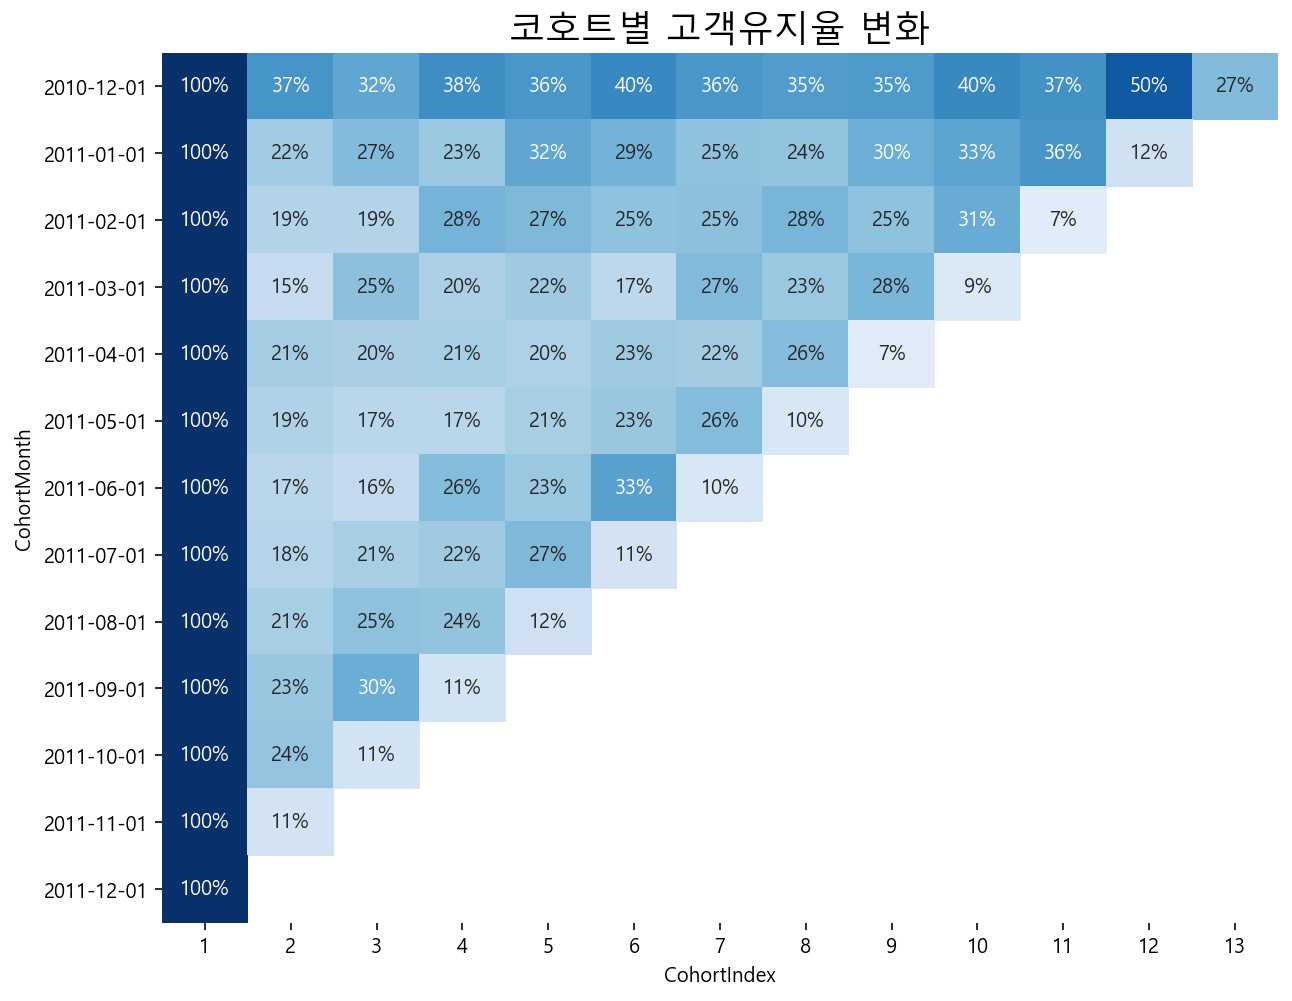

In [242]:
_=plt.figure(figsize=(10, 8))
_=sns.heatmap(retention,
           annot=True,
           fmt='.0%',
           cmap='Blues',
           vmin=0, vmax=0.6, cbar=False)
_=plt.title('코호트별 고객유지율 변화', fontdict={'fontsize':18})

각 코호트의 월별 고객 유지율을 시각화 하여 고객 유지율의 변화를 더 수월하게 확인할 수 있습니다.

# 고객생애가치(CLV)

In [180]:
retail['TotalSum'] = retail['UnitPrice'] * retail['Quantity']

In [211]:
retention_rate, clv

(0.308922268430788, 91.54044471279126)

In [237]:
monthly_revenue = retail.groupby(['CustomerID', 'InvoiceMonth'])['TotalSum'].sum().mean()
retention_rate = retention.mean().mean()
churn_rate = 1 - retention_rate
profit_margin = 0.3

clv = monthly_revenue * profit_margin * (retention_rate / churn_rate)

In [241]:
pd.set_option('display.float', '{:.2f}'.format)
pd.DataFrame({
    '평균 고객유지율':str(round(retention_rate*100, 2)) + '%',
    '고객생애가치(CLV)':'£' + str(round(clv, 2))
}, index=['']).T

,
평균 고객유지율,30.89%
고객생애가치(CLV),£91.54


해당 기업의 평균 고객유지율은 약 31%이며, 한명의 고객으로부터 기대되는 생애기간 동안의 평균 수익은 £91.54임을 확인할 수 있습니다.